In [ ]:
path_data = "drive/MyDrive/kaggle/Final_processed_data"

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [ ]:
files_train = os.listdir(path_data)

In [ ]:
import glob

In [ ]:
image_path = glob.glob(path_data + "/data*")

In [ ]:
import pandas as pd

In [ ]:
df_path= pd.DataFrame(image_path, columns=['path'])

In [ ]:
df_path

,path
0,drive/MyDrive/kaggle/Final_processed_data/data...
1,drive/MyDrive/kaggle/Final_processed_data/data...
2,drive/MyDrive/kaggle/Final_processed_data/data...
3,drive/MyDrive/kaggle/Final_processed_data/data...
4,drive/MyDrive/kaggle/Final_processed_data/data...
...,...
150,drive/MyDrive/kaggle/Final_processed_data/data...
151,drive/MyDrive/kaggle/Final_processed_data/data...
152,drive/MyDrive/kaggle/Final_processed_data/data...
153,drive/MyDrive/kaggle/Final_processed_data/data...


In [ ]:
df_path["mask"] = df_path["path"].str.replace("data_", "mask_")

In [ ]:
df_path.head()

,path,mask
0,drive/MyDrive/kaggle/Final_processed_data/data...,drive/MyDrive/kaggle/Final_processed_data/mask...
1,drive/MyDrive/kaggle/Final_processed_data/data...,drive/MyDrive/kaggle/Final_processed_data/mask...
2,drive/MyDrive/kaggle/Final_processed_data/data...,drive/MyDrive/kaggle/Final_processed_data/mask...
3,drive/MyDrive/kaggle/Final_processed_data/data...,drive/MyDrive/kaggle/Final_processed_data/mask...
4,drive/MyDrive/kaggle/Final_processed_data/data...,drive/MyDrive/kaggle/Final_processed_data/mask...


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_path["path"], df_path["mask"], test_size=0.15, random_state=42)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

In [ ]:
### Checking data

In [ ]:
data = np.load(x_train[0])
mask = np.load(y_train[0])

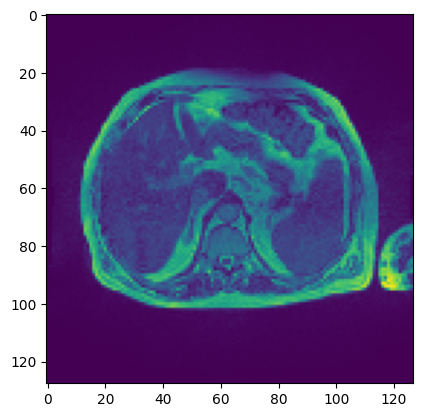

In [ ]:
plt.imshow(data[36])

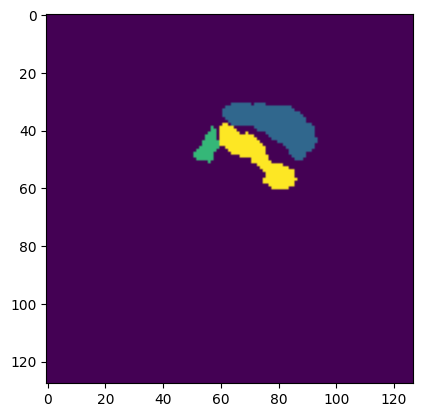

In [ ]:
plt.imshow(mask[36])

In [ ]:
from tqdm import tqdm

In [ ]:
def create_dataset(x, y):
  images = []
  masks = []
  for i in tqdm(range(len(x))):
    image = np.load(x[i])
    mask = np.load(y[i])
    images.append(image)
    masks.append(mask)
  return images, masks

In [ ]:
x_train_images, x_train_masks = create_dataset(x_train.tolist(), y_train.tolist())

100%|██████████| 111/111 [00:02<00:00, 38.10it/s]


In [ ]:
x_val_images, x_val_masks = create_dataset(x_val.tolist(), y_val.tolist())

100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


In [ ]:
x_test_images, x_test_masks = create_dataset(x_test.tolist(), y_test.tolist())

100%|██████████| 24/24 [00:31<00:00,  1.33s/it]


In [ ]:
max_train_slices = np.max([np.max(x.shape[0]) for x in x_train_images])

In [ ]:
max_train_slices

np.int64(144)

In [ ]:
target_slices = 144

In [ ]:
## Create 3d images of same shape

def create_3d_images(image, mask):
  new_images = []
  new_masks = []
  slices_ = image.shape[0]
  for i in range(image.shape[0]):
    resized = cv2.resize(image[i], (128, 128))
    resized_mask = cv2.resize(mask[i], (128, 128))
    new_images.append(resized)
    new_masks.append(resized_mask)
  for i in range(target_slices - slices_):
    new_images.append(np.zeros(shape=(128,128)))
    new_masks.append(np.zeros(shape=(128,128)))
  return new_images, new_masks

In [ ]:
processed_x_train_images = []
processed_x_train_masks = []

for i in tqdm(range(len(x_train_images))):
  images, masks = create_3d_images(x_train_images[i], x_train_masks[i])
  processed_x_train_images.append(images)
  processed_x_train_masks.append(masks)

100%|██████████| 111/111 [00:05<00:00, 21.85it/s]


In [ ]:
processed_x_val_images = []
processed_x_val_masks = []

for i in tqdm(range(len(x_val_images))):
  images, masks = create_3d_images(x_val_images[i], x_val_images[i])
  processed_x_val_images.append(images)
  processed_x_val_masks.append(masks)

100%|██████████| 20/20 [00:00<00:00, 44.90it/s]


In [ ]:
processed_x_test_images = []
processed_x_test_masks = []

for i in tqdm(range(len(x_test_images))):
  images, masks = create_3d_images(x_test_images[i], x_test_images[i])
  processed_x_test_images.append(images)
  processed_x_test_masks.append(masks)

100%|██████████| 24/24 [00:00<00:00, 132.31it/s]


### 3D Modelling

In [ ]:
import tensorflow as tf


In [ ]:
### Losses:


### As this is a imbalanced dataset, using losses: Dice coefficient loss, Jaccard loss, tversky loss, focal tversky loss


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.cast(y_true, 'float32')) # Ensure casting at the start
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32') # Ensure casting at the start
    num_classes = y_pred.shape[-1]
    dice = 0.0
    for i in range(num_classes):
      dice += dice_coefficient(y_true[..., i], y_pred[..., i]) # Use the already casted y_true

    return 1 - (dice / num_classes)


def focal_tversky_loss(y_true, y_pred, smooth=1e-7):
    y_true_pos = K.flatten(K.cast(y_true, 'float32')) # Ensure casting at the start
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.9
    gamma = 2
    tversky = (true_pos + smooth) / (true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
    return K.pow((1 - tversky), gamma)

def combo_loss(y_true, y_pred):
    jaccard_loss_value = jaccard_loss(K.cast(y_true, 'float32'), y_pred) # Ensure casting for jaccard_loss
    focal_loss_value = focal_tversky_loss(K.cast(y_true, 'float32'), y_pred) # Ensure casting for focal_tversky_loss
    return jaccard_loss_value + focal_loss_value

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, 'float32') # Ensure casting at the start
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    jaccard_index = (intersection + smooth) / (union + smooth)
    return 1 - jaccard_index

In [ ]:
### Metrices:
import tensorflow as tf
from tensorflow.keras import backend as K

def Sensitivity(y_true, y_pred):
    y_true = K.cast(y_true, 'float32') # Ensure casting at the start
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def Specificity(y_true, y_pred):
    y_true = K.cast(y_true, 'float32') # Ensure casting at the start
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def Precision(y_true, y_pred):
    y_true = K.cast(y_true, 'float32') # Ensure casting at the start
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def Recall(y_true, y_pred):
    y_true = K.cast(y_true, 'float32') # Ensure casting at the start
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
from tensorflow.keras import layers

def cbam_block(inputs, reduction_ratio=16):
    x = channel_attention(inputs, reduction_ratio)
    x = spatial_attention(x)
    return x

def channel_attention(inputs, reduction_ratio=16):
    channels = inputs.shape[-1]

    avg_pool = layers.GlobalAveragePooling3D()(inputs)
    max_pool = layers.GlobalMaxPooling3D()(inputs)

    # Shared MLP
    shared_dense = tf.keras.Sequential([
        layers.Dense(channels // reduction_ratio, activation='relu'),
        layers.Dense(channels)
    ])

    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)

    # Combine and reshape
    attention = layers.Add()([avg_out, max_out])
    attention = layers.Activation('sigmoid')(attention)
    attention = layers.Reshape((1, 1, 1, channels))(attention) # Reshape for 3D

    return layers.Multiply()([inputs, attention])

def spatial_attention(inputs):
    # Reduce along channel axis: mean and max
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(inputs) # Reduce along last axis
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(inputs) # Reduce along last axis

    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool]) # Concatenate along last axis
    attention = layers.Conv3D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    return layers.Multiply()([inputs, attention])

def resnet_CBAM_module(inputs, filters, kernel_size=3, stride=1):

    x = cbam_block(inputs)

    x = layers.Conv3D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = layers.Conv3D(filters, kernel_size, strides=1, padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if stride != 1 or inputs.shape[-1] != filters:
        shortcut = layers.Conv3D(filters, 1, strides=stride, padding='same')(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

In [ ]:
def model(input_shape):   ### Use resnet_cbam block

  inputs = tf.keras.layers.Input(shape=input_shape)

  contraction_1 = tf.keras.layers.Conv3D(16, kernel_size=3, padding='same')(inputs)     ### 128, 128, 16
  contraction_1 = tf.keras.layers.BatchNormalization()(contraction_1)
  contraction_1 = tf.keras.layers.Activation('relu')(contraction_1)
  contraction_1 = tf.keras.layers.Dropout(0.3)(contraction_1)

  contraction_2 = resnet_CBAM_module(contraction_1, 32)
  contraction_2 = tf.keras.layers.Dropout(0.3)(contraction_2)                           ### 128,128,32
  pooling_1 = tf.keras.layers.MaxPooling3D(pool_size=2)(contraction_2)      ### 64,64,32

  contraction_3 = resnet_CBAM_module(pooling_1, 64)                      ### 64, 64, 64
  contraction_3 = tf.keras.layers.Dropout(0.3)(contraction_3)
  pooling_2 = tf.keras.layers.MaxPooling3D(pool_size=2)(contraction_3)   ### 32, 32, 64


  contraction_4 = resnet_CBAM_module(pooling_2, 128)                          ### 32, 32, 128
  contraction_4 = tf.keras.layers.Dropout(0.4)(contraction_4)
  pooling_3 = tf.keras.layers.MaxPooling3D(pool_size=2)(contraction_4)   ### 16, 16, 12

  bottleneck = resnet_CBAM_module(pooling_3, 128)                             ### 4, 4, 512
  bottleneck = tf.keras.layers.Dropout(0.4)(bottleneck)

  expansion_1 = tf.keras.layers.Conv3DTranspose(128, kernel_size=3, strides=2, padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(bottleneck)
  expansion_1 = tf.keras.layers.Dropout(0.2)(expansion_1)
  expansion_1 = tf.keras.layers.concatenate([expansion_1, contraction_4])
  expansion_1 = resnet_CBAM_module(expansion_1, 128)
  expansion_1 = tf.keras.layers.Dropout(0.4)(expansion_1)

  expansion_2 = tf.keras.layers.Conv3DTranspose(128, kernel_size=3, strides=2, padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(expansion_1)
  expansion_2 = tf.keras.layers.Dropout(0.2)(expansion_2)
  expansion_2 = tf.keras.layers.concatenate([expansion_2, contraction_3])
  expansion_2 = resnet_CBAM_module(expansion_2, 128)
  expansion_2 = tf.keras.layers.Dropout(0.3)(expansion_2)

  expansion_3 = tf.keras.layers.Conv3DTranspose(64, kernel_size=3, strides=2, padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(expansion_2)
  expansion_3 = tf.keras.layers.Dropout(0.2)(expansion_3)
  expansion_3 = tf.keras.layers.concatenate([expansion_3, contraction_2])
  expansion_3 = resnet_CBAM_module(expansion_3, 64)
  expansion_3 = tf.keras.layers.Dropout(0.3)(expansion_3)

  outputs = tf.keras.layers.Conv3D(3, kernel_size=1, activation='sigmoid')(expansion_3)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model


In [ ]:
model = model(input_shape=(128, 128, 144, 1))

In [ ]:
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 144, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 128, 128,  │        448 │ input_layer_10[0… │
│                     │ 144, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv3d_24[0][0]   │
│ (BatchNormalizatio… │ 144, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 144, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128, 128,  │          0 │ activation_8[0][… │
│ (Dropout)           │ 144, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ dropout_13[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 16)        │          0 │ dropout_13[0][0]  │
│ (GlobalMaxPooling3… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 16)        │         49 │ global_average_p… │
│ (Sequential)        │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 16)        │          0 │ sequential_5[0][… │
│                     │                   │            │ sequential_5[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 16)        │          0 │ add_10[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1, 1, 1,   │          0 │ activation_9[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_10         │ (None, 128, 128,  │          0 │ dropout_13[0][0], │
│ (Multiply)          │ 144, 16)          │            │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 128, 128,  │          0 │ multiply_10[0][0] │
│                     │ 144, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 128, 128,  │          0 │ multiply_10[0][0] │
│                     │ 144, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 128,  │          0 │ lambda_10[0][0],  │
│ (Concatenate)       │ 144, 2)           │            │ lambda_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 128, 128,  │        687 │ concatenate_5[0]… │
│                     │ 144, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_11         │ (None, 128, 128,  │          0 │ multiply_10[0][0

 Total params: 5,678,093 (21.66 MB)

 Trainable params: 5,674,285 (21.65 MB)

 Non-trainable params: 3,808 (14.88 KB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=combo_loss, metrics=[dice_coefficient, Sensitivity, Specificity, Precision, Recall])

In [ ]:
model_path = "drive/MyDrive/kaggle/GI/unet_3D_GI.h5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoints = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [checkpoints, reduce_lr, early_stop]

In [ ]:
history = model.fit(processed_x_train_images,processed_x_train_masks, epochs=50, validation_data=(processed_x_val_images, processed_x_val_masks), callbacks=callbacks)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

Dice_coefficient_Graph(history)
Loss_Graph(history)
